# Capstone project

## Import relevant packages and libraries # 

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from geopy.geocoders import Nominatim
#pip install geocoder   ### Install geocoder
#!conda install -c conda-forge geocoder -y
import geocoder

## Functions #

### function to detect if there is a postal code in the data frame ## 

In [2]:
def has_post_code(df):
    if (df.columns[0] == 'Postal code'):
        post_code=True
    else:
        post_code=False
    return post_code

### Get coordinates function using geocoder

In [3]:
def get_coordinates(df, City, Country, post_code):
    latitude=[]
    longitude=[]    
    
    if (post_code == True):
        for PostalCode in df.index:

            # initialize your variable to None
            lat_lng_coords = None

            # loop until you get the coordinates
            while(lat_lng_coords is None):
              g = geocoder.arcgis('{}, Toronto, Ontario'.format(PostalCode))#, City, Country))
              lat_lng_coords = g.latlng

            latitude.append(lat_lng_coords[0])
            longitude.append(lat_lng_coords[1])
            
    else: 
        for index in df.index:
            Neighborhood=df.loc[index, 'Neighborhood']
            Borough=df.loc[index, 'Borough']
            #print(UPZ, localidad)
  
            # initialize your variable to None
            lat_lng_coords = None

            # loop until you get the coordinates
            while(lat_lng_coords is None):
              g = geocoder.arcgis('{}, {}, {}, {}'.format(Neighborhood, Borough, City, Country ))
              lat_lng_coords = g.latlng

            latitude.append(lat_lng_coords[0])
            longitude.append(lat_lng_coords[1])
            
    df['Latitude']=latitude
    df['Longitude']=longitude
    return df

### Function to get geographical coordinates of the cities using Nominatim ###

In [4]:
def coordinates(address): 
    #address = 'Bogota, COL'
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude
    #print('The geograpical coordinate of Bogotá are {}, {}.'.format(latitude, longitude))

### Function to get nearby Venues function using Foursquare (from Lab) ###

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Function for One hot encoding and reordering dataframe ###

In [6]:
def one_hot_venues(city_venues):
    # one hot encoding
    city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = city_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]

    #city_onehot.head()

    city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
    return(city_grouped)

### Top Venues per Neighborhood function###

In [7]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Function for sorting dataframe according to most common venues ###

In [8]:
def venues_sorted(city_grouped, num_top_venues):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = city_grouped['Neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted

### Function for K-means clustering for city venues

In [9]:
def kmeans_cities(city_grouped, kclusters):

    city_grouped_clustering = city_grouped.drop('Neighborhood', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)
    return kmeans 

### Function to instert Cluster labels in the dataframe 

In [10]:
def city_merged(neighborhoods_venues_sorted, df, kmeans):    
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    city_merged = df
    city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
    return (city_merged)

### Function to create a folium map and circle mark Neighboorhoods with name and cluster labels ###

In [11]:
def create_map(latitude, longitude, kclusters, city_merged):
    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
    #city_merged=bogota_merged
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighborhood'], city_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=8,
            popup=label,
            color=rainbow[int(cluster)],
            fill=True,
            fill_color=rainbow[int(cluster)],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters
#map_clusters

## Create Dataframes #

### Create Dataframe of  Neighborhoods for Bogotá, Colombia from Wikipedia

In [12]:
url='https://es.wikipedia.org/wiki/Anexo:Barrios_de_Bogot%C3%A1'
lista=pd.read_html(url)
df_bog=lista[0]
df_bog=df_bog.drop('Barrio', axis=1)
df_bog=df_bog.drop('Número UPZ', axis=1)
df_bog.rename(columns = {'Unidad de Planeamiento Zonal':'Neighborhood'}, inplace = True)
df_bog.rename(columns = {'Localidad':'Borough'}, inplace = True)
#df.head()


city=[]    
for i in range (len(df_bog)):
    city.append('Bogota')
df_bog.insert(0, 'City', city)

### Create Dataframe of  Neighborhoods for Toronto, Canada from Wikipedia ##

In [13]:
url2='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
lista2=pd.read_html(url2)
df_tor=lista2[0]
post_code=has_post_code(df_tor)
Indexes=df_tor[df_tor['Borough'] == 'Not assigned'].index   #finds not assigned rows
df_tor.drop(Indexes, inplace=True)                          #drops not assigned rows
df_tor = df_tor.reset_index(drop=True)                      #resets index
df_tor.drop('Postal code', axis=1, inplace=True)            #drops postal code column

city=[]    
for i in range (len(df_tor)):
    city.append('Toronto')
df_tor.insert(0, 'City', city)

### Create Dataframe of Neighborhoods for Berlin, Germany from Wikipedia  

In [14]:
url='https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin#Localities'
lista=pd.read_html(url)
Bezirke=lista.pop(14)
lista.pop(0)
lista.pop(0)
lista.pop(-1)
lista.pop(-1)
# Berlin Boroughs
Boroughs=['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow', 'Charlottenburg-Wilmersdorf', 'Spandau', 'Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln', 'Treptow-Köpenick', 'Marzahn-Hellersdorf', 'Lichtenberg', 'Reinickendorf']

for i in range (len(Boroughs)):
    Borough=[]    
    for j in range (len(lista[i])):
        Borough.append(Boroughs[i])
    lista[i].insert(0, 'Borough', Borough)

df_ber=pd.concat(lista)
df_ber.drop(['Area in km²', 'Population as of 2008','Density inhabitants per km²', 'Map'], axis=1, inplace=True)
df_ber.reset_index(drop=True, inplace=True)

for index in df_ber.index:
    df_ber['Locality'][index]=(df_ber['Locality'][index])[7:]

df_ber.rename(columns = {'Locality':'Neighborhood'}, inplace = True)

city=[]    
for i in range (len(df_ber)):
    city.append('Berlin')
df_ber.insert(0, 'City', city)

### Get coordinates for Neighboorhoods for all the cities ##

In [15]:
df_bog=get_coordinates(df_bog, 'Bogota', 'COL', False)
df_tor=get_coordinates(df_tor, 'Toronto', 'Ontario', False)
df_ber=get_coordinates(df_ber, 'Berlin', 'Germany', False)

### Concatenate dataframes 

In [16]:
df_total=pd.concat([df_tor, df_bog, df_ber])
df_total.reset_index(drop=True, inplace=True)
df_total

,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.758872,-79.320292
1,Toronto,North York,Victoria Village,43.731540,-79.314280
2,Toronto,Downtown Toronto,Regent Park / Harbourfront,43.660690,-79.360310
3,Toronto,North York,Lawrence Manor / Lawrence Heights,43.723570,-79.437110
4,Toronto,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.666630,-79.393268
...,...,...,...,...,...
306,Berlin,Reinickendorf,Waidmannslust,52.575450,13.349700
307,Berlin,Reinickendorf,Lübars,52.575450,13.349700
308,Berlin,Reinickendorf,Wittenau,52.575450,13.349700
309,Berlin,Reinickendorf,Märkisches Viertel,52.596800,13.358310


## Exploring and Clustering#

###  Getting Geographical coordinates of the cities  ###

In [17]:
latitude_bog, longitude_bog=coordinates('Bogota, COL')
latitude_tor, longitude_tor=coordinates('Toronto, Ontario')
latitude_ber, longitude_ber=coordinates('Berlin, Germany')

### Explore Cities in Foursquare ###

In [344]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20200424' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [18]:
CLIENT_ID = '5325RSOXV3SY4GEG5IH5R4DL3ZEPY20FMM4VYIAN302XEW1N' # your Foursquare ID
CLIENT_SECRET = 'UUKN2QZGA2FVTWQCTTOOSAMX53BPWQXVCYAHGVMLNFGX1IEJ' # your Foursquare Secret
VERSION = '20200415' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5325RSOXV3SY4GEG5IH5R4DL3ZEPY20FMM4VYIAN302XEW1N
CLIENT_SECRET:UUKN2QZGA2FVTWQCTTOOSAMX53BPWQXVCYAHGVMLNFGX1IEJ


### Get nearby venues for each Neighborhood  ###

In [19]:
bogota_venues = getNearbyVenues(names=df_bog['Neighborhood'],
                                  latitudes=df_bog['Latitude'],
                                  longitudes=df_bog['Longitude']                             
                                  )


Paseo de los Libertadores
Verbenal
La Uribe
San Cristóbal Norte
Toberín
Los Cedros
Usaquén
Country Club
Santa Bárbara
El Refugio
San Isidro-Patios
Pardo Rubio
Chicó Lago
Chapinero
Sagrado Corazón
La Macarena
Las Nieves
Las Cruces
Lourdes
San Blas
Sociego
20 de Julio
La Gloria
Los Libertadores
La Flora
Danubio
Gran Yomasa
Comuneros
Alfonso López
Parque Entrenubes
Ciudad Usme
Venecia
Tunjuelito
Apogeo
Bosa Occidental
Bosa Central
El Porvenir
Tintal Sur
Castilla
Américas
Carvajal
Kennedy Central
Timiza
Tintal Norte
Calandaima
Corabastos
Gran Britalia
Patio Bonito
Las Margaritas
Bavaria
Fontibón
Fontibón-San Pablo
Zona Franca
Ciudad Salitre Occidente
Granjas de Techo
Modelia
Capellanía
Aeropuerto Eldorado
Las Ferias
Minuto de Dios
Boyacá Real
Santa Cecilia
Bolivia
Garcés Navas
Engativá
Jardín Botánico
Álamos
La Academia
Guaymaral
San José de Bavaria
Britalia
El Prado
La Alhambra
Casablanca Suba
Niza
La Floresta
Suba
El Rincón
Tibabuyes
Los Andes
12 de Octubre
Los Alcázares
Parque Salitre
G

In [20]:
toronto_venues = getNearbyVenues(names=df_tor['Neighborhood'],
                                 latitudes=df_tor['Latitude'],
                                 longitudes=df_tor['Longitude']
                                 )

Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Do

In [21]:
berlin_venues = getNearbyVenues(names=df_ber['Neighborhood'],
                                  latitudes=df_ber['Latitude'],
                                  longitudes=df_ber['Longitude']                             
                                  )

Mitte
Moabit
Hansaviertel
Tiergarten
Wedding
Gesundbrunnen
Friedrichshain
Kreuzberg
Prenzlauer Berg
Weißensee
Blankenburg
Heinersdorf
Karow
Stadtrandsiedlung Malchow
Pankow
Blankenfelde
Buch
Französisch Buchholz
Niederschönhausen
Rosenthal
Wilhelmsruh
Charlottenburg
Wilmersdorf
Schmargendorf
Grunewald
Westend
Charlottenburg-Nord
Halensee
Spandau
Haselhorst
Siemensstadt
Staaken
Gatow
Kladow
Hakenfelde
Falkenhagener Feld
Wilhelmstadt
Steglitz
Lichterfelde
Lankwitz
Zehlendorf
Dahlem
Nikolassee
Wannsee
Schöneberg
Friedenau
Tempelhof
Mariendorf
Marienfelde
Lichtenrade
Neukölln
Britz
Buckow
Rudow
Gropiusstadt
Alt-Treptow
Plänterwald
Baumschulenweg
Johannisthal
Niederschöneweide
Altglienicke
Adlershof
Bohnsdorf
Oberschöneweide
Köpenick
Friedrichshagen
Rahnsdorf
Grünau
Müggelheim
Schmöckwitz
Marzahn
Biesdorf
Kaulsdorf
Mahlsdorf
Hellersdorf
Friedrichsfelde
Karlshorst
Lichtenberg
Falkenberg
Malchow
Wartenberg
Neu-Hohenschönhausen
Alt-Hohenschönhausen
Fennpfuhl
Rummelsburg
Reinickendorf
Tegel
Kon

### Save foursquare data on a csv file

In [22]:
bogota_venues.to_csv('bogota_venues.csv')
toronto_venues.to_csv('toronto_venues.csv')
berlin_venues.to_csv('berlin_venues.csv')

### Concatenate the results of the venues search in a single Dataframe

In [23]:
df_venues=pd.concat([toronto_venues, bogota_venues, berlin_venues])
df_venues.reset_index(drop=True, inplace=True)  #Reset index of dataframe

### One hot encoding and frecuency of the venues for each Neighboorhood and sorting the DF with the N most comon Venues##

In [79]:
del cities_merged
cities_grouped=one_hot_venues(df_venues)
del cities_venues_sorted
cities_venues_sorted=venues_sorted(cities_grouped, 7)   # Number of most common Venues to take into account

### Instert Cluster labels into the Venues sorted dataframe an create cities_merged dataframe ##

In [80]:
kclusters=3
cities_merged=city_merged(cities_venues_sorted, df_total, kmeans_cities(cities_grouped, kclusters))

### Create Folium Map Toronto ###

In [81]:
ind=cities_merged.loc[cities_merged['Cluster Labels'].isnull() == True].index
cities_merged.drop(ind, inplace=True)    #drops rows with NaN values
map_clusters = create_map(latitude_tor, longitude_tor, kclusters, cities_merged)
map_clusters

### Create Folium Map Bogotá ###

In [82]:
ind=cities_merged.loc[cities_merged['Cluster Labels'].isnull() == True].index
cities_merged.drop(ind, inplace=True)    #drops rows with NaN values
map_clusters = create_map(latitude_bog*0.98, longitude_bog, kclusters, cities_merged)
map_clusters

### Create Folium Map Berlin  ###

In [83]:
ind=cities_merged.loc[cities_merged['Cluster Labels'].isnull() == True].index
cities_merged.drop(ind, inplace=True)    #drops rows with NaN values
map_clusters = create_map(latitude_ber, longitude_ber, kclusters, cities_merged)
map_clusters

# Results and observations # 

### Count cluster labels for each city and get percentages

In [84]:
toronto=cities_merged.loc[cities_merged['City'] == 'Toronto']
toronto_count=(toronto['Cluster Labels'].value_counts(normalize=True)).to_frame()
bogota=cities_merged.loc[cities_merged['City'] == 'Bogota']
bogota_count=(bogota['Cluster Labels'].value_counts(normalize=True)).to_frame()
berlin=cities_merged.loc[cities_merged['City'] == 'Berlin']
berlin_count=(berlin['Cluster Labels'].value_counts(normalize=True)).to_frame()

### Clean and prepare dataframes for plot

In [85]:
toronto_count=(toronto_count['Cluster Labels']*100).to_frame()
toronto_count.reset_index(inplace=True)
toronto_count.rename(columns={'index':'Cluster'}, inplace=True)
toronto_count.rename(columns={'Cluster Labels':'Percentage'}, inplace=True)
toronto_count.sort_values('Cluster')
toronto_count.sort_values('Cluster', inplace=True)
toronto_count.set_index('Cluster', drop=True, inplace=True)
toronto_count=toronto_count.round(1)


bogota_count=(bogota_count['Cluster Labels']*100).to_frame()
bogota_count.reset_index(inplace=True)
bogota_count.rename(columns={'index':'Cluster'}, inplace=True)
bogota_count.rename(columns={'Cluster Labels':'Percentage'}, inplace=True)
bogota_count.sort_values('Cluster')
bogota_count.sort_values('Cluster', inplace=True)
bogota_count.set_index('Cluster', drop=True, inplace=True)
bogota_count=bogota_count.round(1)

berlin_count=(berlin_count['Cluster Labels']*100).to_frame()
berlin_count.reset_index(inplace=True)
berlin_count.rename(columns={'index':'Cluster'}, inplace=True)
berlin_count.rename(columns={'Cluster Labels':'Percentage'}, inplace=True)
berlin_count.sort_values('Cluster')
berlin_count.sort_values('Cluster', inplace=True)
berlin_count.set_index('Cluster', drop=True, inplace=True)
berlin_count=berlin_count.round(1)

### Plot statistics of clusters

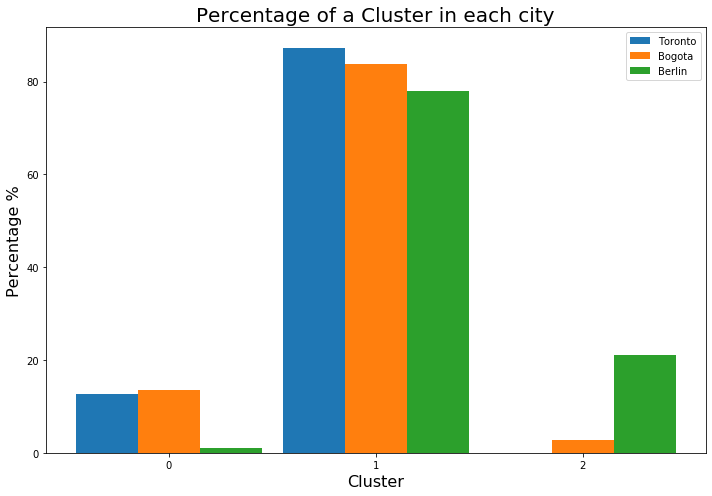

In [86]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels=[]
percentage_tor=[]
for i in range(kclusters):
    if i in  toronto_count.index:
        percentage_tor.append(toronto_count['Percentage'][i])
    else:
        percentage_tor.append(0)
    labels.append(i)

percentage_bog=[]
for i in range(kclusters):
    if i in  bogota_count.index:
        percentage_bog.append(bogota_count['Percentage'][i])
    else:
        percentage_bog.append(0)
        
percentage_ber=[]
for i in range(kclusters):
    if i in  berlin_count.index:
        percentage_ber.append(berlin_count['Percentage'][i])
    else:
        percentage_ber.append(0)

#labels = ['G1', 'G2', 'G3', 'G4', 'G5']
#men_means = [20, 34, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width, percentage_tor, width, label='Toronto')
rects2 = ax.bar(x , percentage_bog, width, label='Bogota')
rects3 = ax.bar(x + width, percentage_ber, width, label='Berlin')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.figsize=(10, 6)
ax.set_ylabel('Percentage %', fontsize=16)
ax.set_xlabel('Cluster', fontsize=16)
ax.set_title('Percentage of a Cluster in each city', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


#def autolabel(rects):
#    """Attach a text label above each bar in *rects*, displaying its height."""
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
fig.tight_layout()

plt.show()

## Observations: 
### In the plot you can notice that the 3 cities have pretty much the same distribution of clusters according to the venues found in Foursquare. It doesn´t matter how many clusters you make and how many most common Venues you take into account the distribution is pretty much the same. 